# Dataset MIMII

Read a good description of the dataset here:

https://github.com/BA-HanseML/NF_Prj_MIMII_Dataset/blob/master/doc/about_the_dataset.md 


A showroom of the recordings is available here:
https://ba-hanseml.github.io/MIMII_show_room/showroom.html

https://github.com/BA-HanseML/NF_Prj_MIMII_Dataset/blob/master/NF_Prj_MIMII_presentation_short.pdf

## Machine parts
There are 4 machine parts and their audio recordings. Each machine part has a normal and abnormal recording.

- pump
- valve
- rail slider
- fan

## Dataset Structure
https://github.com/BA-HanseML/NF_Prj_MIMII_Dataset/blob/master/dataset/dataset_struct.md 


In [2]:
import os, sys
import glob
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import matplotlib.pyplot as plt

Unable to revert mtime: /Library/Fonts


# General config

In [67]:
base_data_path = "./dataset"

# SNRs = ['6dB', '0dB', 'min6dB']
# machines = ['pump', 'valve', 'fan', 'slider']
# IDs = ['00', '02', '04', '06']

def get_data_path(SNR, machine, ID):
    path = glob.glob(base_data_path + \
                     "{}_{}/*/id_{}/*/*".format(SNR, machine, ID))

# Direct paths to audio files
paths = glob.glob(data_path+"0_dB_fan/*/id_00/*/*")[0:100]
paths.sort()

Anudeep some thoughts on the dataloader.
- If we consider a supervised method. The dataloader should only read the normal data and store [spectrogram, label]. label can be [0, 1, 2, 3] (pump, valve, fan, slider )
- If we consider a 1-class unsupervised method. We should train only on normal data of a particular class. ie
class MIMII(Dataset):
    def __init__(self, data_paths, machine).
and the label can be [1, 0]. ie normal or abnormal 


In [114]:
from tqdm import trange

class MIMII(Dataset):
    def __init__(self, data_paths):
        
        # Parameters for conversion to MEL spectrogram 
        self.n_mels = 64
        self.frames = 5
        self.n_fft = 2048
        self.hop_length = 512
        self.power = 2.0
        self.data_paths = data_paths
        
        # convert audio to spectograms
        self.spectrograms = []
        self.sampling_rates = []
        self.labels = []
        
        t = trange(len(data_paths), desc='Converting audio files to spectrograms', leave=True)        
        for index in t:
            t.set_description("Converting audio file no. %i of %i" % (index, len(data_paths)))
            t.refresh()
            
            wav_file_path = data_paths[index]
            if "abnormal" in wav_file_path:
                curr_label = 1
            elif "normal" in wav_file_path:
                curr_label = 0
            else:
                curr_label = -1
            
            curr_spectrogram, curr_sr = self.convert_to_spectrogram(wav_file_path)
            self.spectrograms.append(curr_spectrogram)
            self.labels.append(curr_label)
            self.sampling_rates.append(curr_sr)
            
            
    def __getitem__(self, index):
        
        # return and indexed item from the list
        # NOTE: There are 8 spectrograms per audio, one for each microphone
        return torch.from_numpy(self.spectrograms[index]), torch.from_numpy(np.array([self.labels[index]])),\
    torch.from_numpy(self.sampling_rates[index])
    
        
    def __len__(self):
        
        # number of samples loaded
        return len(self.data_paths)
    
        
    def convert_to_spectrogram(self, wav_file_path):
        signal, sampling_rate = self.load_sound_file(wav_file_path)
        
#         ## Perform fourier transform
#         stft = librosa.stft(signal, n_fft=self.n_fft, hop_length=self.hop_length)
#         # Map the magnitude to a decibel scale:
#         dB = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        
        ## Mel spectrogram calculation
        db_mels = []
        for channel in range(signal.shape[0]):
            mel = librosa.feature.melspectrogram(signal[channel], sr=sampling_rate, n_fft=self.n_fft, hop_length=self.hop_length,\
                                             n_mels=self.n_mels)
            db_mel = librosa.power_to_db(mel, ref=np.max)
            db_mels.append(db_mel)
        
        return np.array(db_mels), np.array(sampling_rate)
        
    
    def load_sound_file(self, wav_name, mono=False, channel=0):
        multi_channel_data, sampling_rate = librosa.load(wav_name, sr=None, mono=mono)
        signal = np.array(multi_channel_data)
    
        return signal, sampling_rate
    
    transform = T.Compose([T.ToPILImage(), T.ToTensor()])
        

In [115]:
dataset = MIMII(paths)

Converting audio file no. 99 of 100: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


In [116]:
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=2)
iterable = iter(dataloader)

In [117]:
x, y, z = iterable.next()

# Visualization of spectrograms

(1, 8, 64, 313) [[1]] (1,)


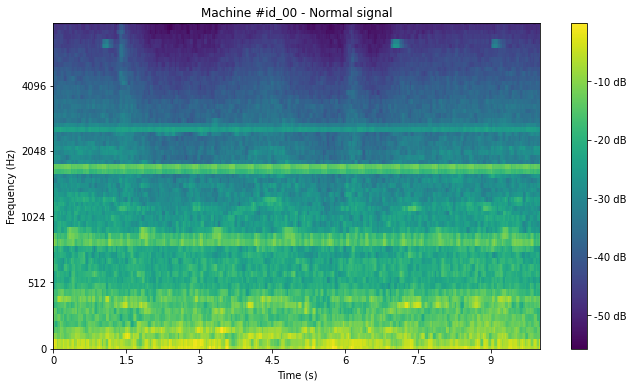

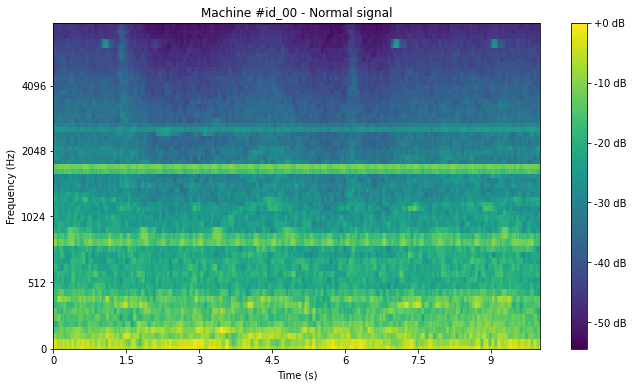

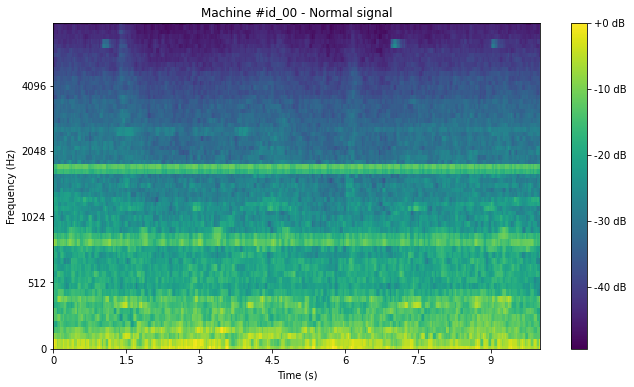

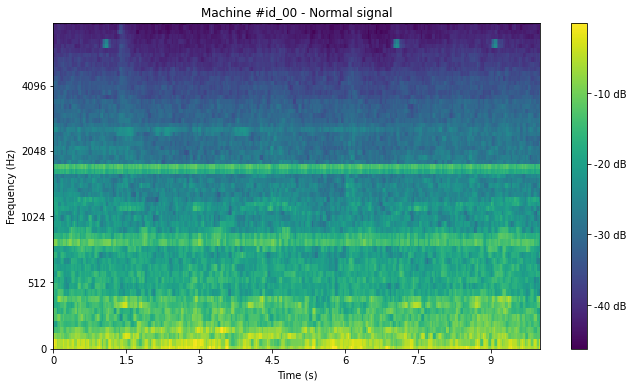

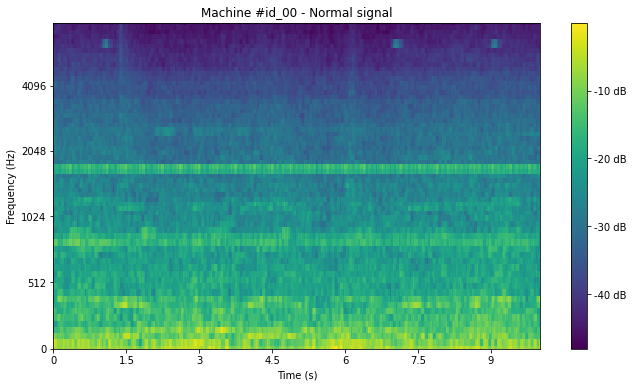

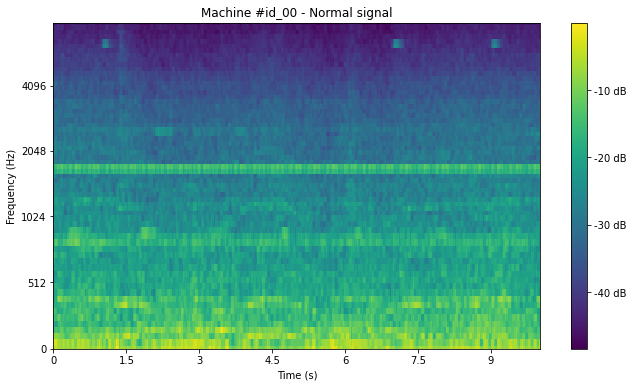

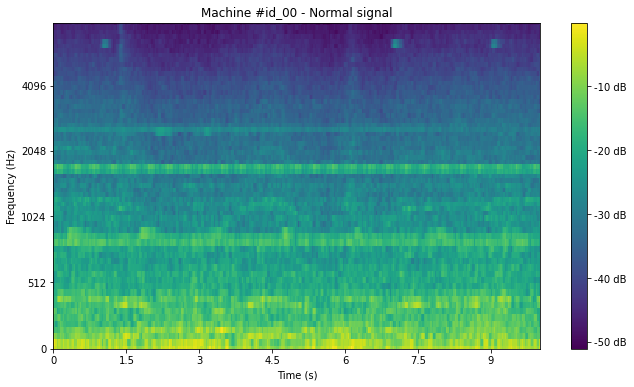

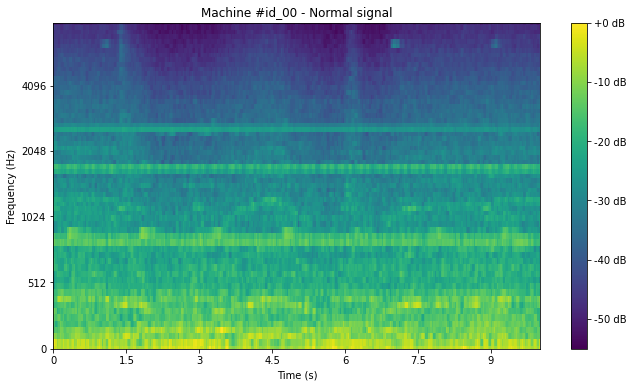

In [121]:
x_np = x.numpy()
y_np = y.numpy()
z_np = z.numpy()
print(x_np.shape, y_np, z_np.shape)

#f, ax = plt.figure(2, 4)

for k in range(8):
    fig = plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    librosa.display.specshow(x_np[0][k], sr=z_np[0], hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title('Machine #id_00 - Normal signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')